In [1]:
# 下载数据：27G
# import sys
# import labptptm2
# labptptm2.clone_store('lab2_data', log=sys.stdout)
# labptptm2.config.store = 'lab2_data'

In [2]:
## 3. import modules
import jax
from collections import namedtuple
from typing import Any, Callable, Iterable, Optional, Tuple, Union
import flax.linen as nn
from flax.linen.initializers import lecun_normal, variance_scaling, zeros
from flax.core import freeze, unfreeze
from functools import partial, wraps
import matplotlib.pyplot as plt
from jax import random
import jax.numpy as jnp
import commplax.adaptive_filter
import numpy as np
default_kernel_init = lecun_normal()

def normal_init(key,shape, dtype = jnp.float32):
    k1,k2 = random.split(key)
    x = random.normal(k1,shape)  + 1j * random.normal(k2,shape)
    return x.astype(dtype)

def show_tree(tree):
    return jax.tree_map(lambda x:x.shape, tree)

##  测试 core 使用
from commplax.module import core, layer
from commplax.util import wrapped_partial as wpartial
from commplax.module.layer import make_layer
key = random.PRNGKey(0)
dnn = make_layer(core.hp_net)

In [3]:
class NN(nn.Module):
    @nn.compact
    def __call__(self,inputs):
        x = inputs
        y = nn.Dense(features=1)(x)
        y = dnn()(y)
        return y

In [4]:
## xop.frame
def frame(array, flen, fstep):
    n = array.shape[0]
    fnum = 1 + (n - flen) // fstep
    array = array[:(fnum - 1) * fstep + flen,...]

    ind = jnp.arange(flen)[None,:] + fstep * jnp.arange(fnum)[:,None]
    return array[ind,...]  # 取以 ind 为索引的若干行

frame(jnp.arange(200), 10, 10)

DeviceArray([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
             [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19],
             [ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29],
             [ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39],
             [ 40,  41,  42,  43,  44,  45,  46,  47,  48,  49],
             [ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59],
             [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69],
             [ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79],
             [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89],
             [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99],
             [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
             [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
             [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
             [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
             [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
             [150, 151, 1

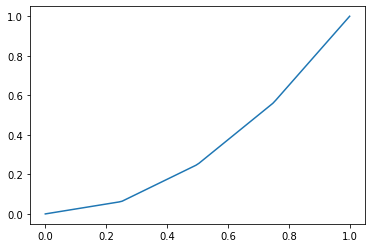

In [5]:
## jnp.interp
xp = jnp.linspace(0,1,5)
yp = xp ** 2
x = jnp.linspace(0,1,100)
y = jnp.interp(x,xp,yp)
plt.plot(x,y) 

In [15]:
##  Test variable
class TestNN(nn.Module):
    @nn.compact
    def __call__(self, inputs):
        x = inputs
        var = self.variable('af','x_pls',lambda x: x+1, x)  # 只会在初始化时调用 init 函数
        var.value *= 2
        return x + var.value

net = TestNN()
param = net.init(key,jnp.ones(1))

net.apply(param,jnp.ones(1)*2, mutable='af')  # 使用mutuable 选项会额外返回 'af' 的更新值

(DeviceArray([10.], dtype=float32),
 FrozenDict({
     af: {
         x_pls: DeviceArray([8.], dtype=float32),
     },
 }))

In [16]:
net.apply({},jnp.ones(1), mutable='af')

(DeviceArray([5.], dtype=float32),
 FrozenDict({
     af: {
         x_pls: DeviceArray([4.], dtype=float32),
     },
 }))

In [17]:
# lax.scan  循环扫描的轴是一个Pytree中每个 node的 leading axis
# xop.scan
from jax import lax
from commplax import xop
a = np.array([1, 2, 3, 5, 7, 11, 13, 17])
result_init = 0
xop.scan(lambda carry, x: (carry+x, carry+x), result_init, a)

(DeviceArray(59, dtype=int32),
 DeviceArray([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32))